In [12]:
# -- IMPORTS --
'''
%pip install livelossplot
%pip install torcheval
%pip install torchmetrics
'''
import os
os.chdir('/workplace/flowmind/')
print("working in: " + os.getcwd())

#%run /workplace/flowmind/setup.py

import csv
import sys

# torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics.functional as FM
#import torchvision.transforms.functional as TF
import torchvision.transforms as T
from torchvision.transforms.functional import InterpolationMode


from torcheval.metrics import MulticlassAccuracy

# flowmind imports
#from flowmind.processing.dataloaders.flowpic import create_flowpic_dataloader 
from flowmind.datasets.mirage import remap_label_mirage19
from flowmind.processing.dataloaders.common import FlowData

# livelossplot imports
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot

# others
from datetime import datetime, timedelta
import random

os.chdir('/workplace/xcocek00/')
print("working in: " + os.getcwd())
from flowpic import create_flowpic_dataloader

csv.field_size_limit(sys.maxsize)

# sets the device to use gpu if available, if not, use cpu
device = torch.device(f"cuda" if torch.cuda.is_available() else "cpu")


working in: /workplace/flowmind
working in: /workplace/xcocek00


In [13]:
# -- TESTS --

# dimensions validation
def dim_val(dl_train) -> None:
    print("dl train: ", type(dl_train))
    for (flowpic1, flowpic2, labels) in dl_train:
        print("flowpic1", type(flowpic1))
        print(flowpic1.shape, flowpic2.shape)
        break    

# print batch
def print_batch(dl_train) -> None:
    for batch in dl_train:
        torch.set_printoptions(threshold=sys.maxsize)
        print(batch)
        break
    
# debug batch    
def debug_batch(dl):
    for (flowpic1, flowpic2, labels) in dl:
        print("flowpic1 type:", type(flowpic1))
        print("flowpic2 type:", type(flowpic2))
        # If they are lists, let's check each item
        if isinstance(flowpic1, list):
            print(f"flowpic1 has {len(flowpic1)} items.")
            print("Shapes of flowpic1 items:")
            for i, fp in enumerate(flowpic1):
                print(type(fp))
                print(f"  Item {i}: {fp.shape}")
                break

        if isinstance(flowpic2, list):
            print(f"flowpic2 has {len(flowpic2)} items.")
            print("Shapes of flowpic2 items:")
            for i, fp in enumerate(flowpic2):
                print(f"  Item {i}: {fp.shape}")

        print("labels:", labels)
        break  # Just inspect the first batch

In [14]:
# -- FlowPic rotation --

def flowpic_rotation(flowpic):
    '''
    FlowPic rotation augmentation - rotating flowpic within -10° and 10°

    Args:
        flowpic: original flowpic

    Returns:
        rotated flowpic
    '''
    rotate_transform = T.RandomRotation(degrees=(-10,10))
    return rotate_transform(flowpic)

In [15]:
# -- DATA LOADER --

# 0 - debug prints are turned off
# 1 - debug prints are turned ofn
DEBUG = 0

dl_train = create_flowpic_dataloader(
    #dir_path="/workplace/xcocek00/test_b.csv",
    dir_path="/workplace/datasets/mirage19/processed/splits/train.csv",
    batch_size=32,
    meta_key="BF_label",
    time_bins = [0, 9.375, 18.75, 28.125, 37.5, 46.875, 56.25, 65.625, 75.0, 84.375, 93.75, 103.125, 112.5, 121.875, 131.25, 140.625, 150.0, 159.375, 168.75, 178.125, 187.5, 196.875, 206.25, 215.625, 225.0, 234.375, 243.75, 253.125, 262.5, 271.875, 281.25, 290.625, 300.0],
    length_bins = [0, 46.875, 93.75, 140.625, 187.5, 234.375, 281.25, 328.125, 375.0, 421.875, 468.75, 515.625, 562.5, 609.375, 656.25, 703.125, 750.0, 796.875, 843.75, 890.625, 937.5, 984.375, 1031.25, 1078.125, 1125.0, 1171.875, 1218.75, 1265.625, 1312.5, 1359.375, 1406.25, 1453.125, 1500.0],
    # dp_transform=lambda dp: dp.map(remap_label_mirage19).in_memory_cache(),
)
dl_val = create_flowpic_dataloader(
    dir_path="/workplace/datasets/mirage19/processed/splits/val.csv",
    batch_size=32,
    meta_key="BF_label",
    time_bins = [0, 9.375, 18.75, 28.125, 37.5, 46.875, 56.25, 65.625, 75.0, 84.375, 93.75, 103.125, 112.5, 121.875, 131.25, 140.625, 150.0, 159.375, 168.75, 178.125, 187.5, 196.875, 206.25, 215.625, 225.0, 234.375, 243.75, 253.125, 262.5, 271.875, 281.25, 290.625, 300.0],
    length_bins = [0, 46.875, 93.75, 140.625, 187.5, 234.375, 281.25, 328.125, 375.0, 421.875, 468.75, 515.625, 562.5, 609.375, 656.25, 703.125, 750.0, 796.875, 843.75, 890.625, 937.5, 984.375, 1031.25, 1078.125, 1125.0, 1171.875, 1218.75, 1265.625, 1312.5, 1359.375, 1406.25, 1453.125, 1500.0],
    # dp_transform=lambda dp: dp.map(remap_label_mirage19).in_memory_cache(),
)    


if DEBUG:    
    #print(type(dl_train))
    dim_val(dl_train)
    print_batch(dl_train)
    #debug_batch(dl_train)

/root/miniconda3/lib/python3.12/site-packages/torch/utils/data/datapipes/utils/common.py:145: UserWarning: Local function is not supported by pickle, please use regular python function or functools.partial instead.
  warnings.warn(


In [16]:
# -- simple MLP --
# FIXME: DELETE

class MLP(nn.Module):
    def __init__(self, channels, height, width, embed_dim=120):
        super().__init__()
        input_size = channels * height * width

        self.encoder = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, embed_dim),
        )

    def forward(self, x):
        # x shape: [batch_size, channels, height, width]
        x = x.flatten(start_dim=1)  # -> [batch_size, channels*height*width]
        z = self.encoder(x)         # -> [batch_size, embed_dim]
        z = F.normalize(z, dim=1)   # L2 normalize
        return z


In [17]:
# -- CNN architecture --

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # conv + pooling layers
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)

        # fully connected (fc) layers
        self.fc1 = nn.Linear(400, 120) # 16*5*5 = 400 
        self.fc2 = nn.Linear(120, 120)
        self.fc3 = nn.Linear(120, 30)

    def forward(self, x):
        # conv + ReLU + pool 1
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        # conv + ReLU + pool 2
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        # flatten for fc layers
        x = x.view(x.size(0), -1)
        
        # fc layers
        x = F.relu(self.fc1(x))
        
        h = F.relu(self.fc2(x))   
        z = self.fc3(h)           
        
        # L2 normalize
        z = F.normalize(z, dim=1)
        
        '''
        Returns:
          h: 120-d representation
          z: 30-d projection'
        '''
        return h, z

In [18]:
# -- accuracy calculation --

def contrastive_accuracy(z1, z2, temperature=0.07):
    '''
    Computes contrastive accuracy using a multiclass approach.
    
    Args:
        z1: tensor 
        z2: tensor 
        temperature: scaling factor
    
    '''
    batch_size = z1.size(0)
    embeddings = torch.cat([z1, z2], dim=0)
    
    # pairwise cosine similarity scaled by temperature
    sim_matrix = torch.matmul(embeddings, embeddings.T) / temperature

    # mask self-similarity
    mask = torch.eye(2 * batch_size, dtype=torch.bool, device=sim_matrix.device)
    sim_matrix.masked_fill_(mask, -float("inf"))
    
    # predictions
    preds = sim_matrix.argmax(dim=1)
    
    # targets
    targets = (torch.arange(2 * batch_size, device=sim_matrix.device) + batch_size) % (2 * batch_size)
    
    acc = FM.accuracy(preds, targets, task="multiclass", num_classes=2 * batch_size)
    return acc

In [19]:
# -- training --

def train(model, dataloader, optimizer, contrastive_loss_fn, log):
    '''
    Training loop

    Args:
        model: chosen model for training
        dataloader: pytorch dataloader created by create_flowpic_dataloader function
        optimizer: chosen optimizer
        contrastive_loss_fn: contrastive loss function (NT-Xent)
        log: for log collection

    Returns:
        Avarage loss 
    '''

    model.train()
    total_loss = 0.0
    batches = 0
    acc_total = 0.0

    # label not needed in -> _
    for flowpic1, flowpic2, _ in dataloader:
       
        # apply rotation augmentation
        flowpic1 = flowpic_rotation(flowpic1)
        flowpic2 = flowpic_rotation(flowpic2)
        
        flowpic1, flowpic2 = flowpic1.to(device), flowpic2.to(device)

        optimizer.zero_grad()

        # forward pass to get embeddings
        h1, z1 = model(flowpic1)  
        h2, z2 = model(flowpic2)  

        # contrastive loss
        loss = contrastive_loss_fn(z1, z2)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        batches += 1
        
        batch_acc = contrastive_accuracy(z1, z2, temperature=0.07)
        acc_total += batch_acc.item()

    avg_loss = total_loss / batches
    avg_acc = acc_total / batches
    log["loss"] = avg_loss
    log["accuracy"] = avg_acc

    return avg_loss

def val(model, dataloader, contrastive_loss_fn, log):
    '''
    Validation loop

    Args:
        model: chosen model for training
        dataloader: pytorch dataloader created by create_flowpic_dataloader function
        contrastive_loss_fn: contrastive loss function (NT-Xent)
        log: for log collection

    Returns:
        Avarage loss 
    '''
    with torch.no_grad():
        model.eval()
        total_loss = 0.0
        batches = 0
        acc_total = 0.0

        # label not needed in -> _
        for flowpic1, flowpic2, _ in dataloader:
            
            # apply rotation augmentation
            flowpic1 = flowpic_rotation(flowpic1)
            flowpic2 = flowpic_rotation(flowpic2)

            flowpic1, flowpic2 = flowpic1.to(device), flowpic2.to(device)

            # forward pass to get embeddings
            h1, z1 = model(flowpic1)  
            h2, z2 = model(flowpic2)  

            # contrastive loss
            loss = contrastive_loss_fn(z1, z2)

            total_loss += loss.item()
            batches += 1
            
            batch_acc = contrastive_accuracy(z1, z2, temperature=0.07)
            acc_total += batch_acc.item()

        avg_loss = total_loss / batches
        avg_acc = acc_total / batches
        log["val_loss"] = avg_loss
        log["val_accuracy"] = avg_acc

    return avg_loss



In [20]:
# -- loss function --

def nt_xent_loss(z1: torch.Tensor, z2: torch.Tensor, temperature: float = 0.07) -> torch.Tensor:
    '''
    NT-Xent (Normalized Temperature-Scaled Cross-Entropy) loss function
    
    Args:
        z1: tensor 
        z2: tensor 
        temperature: scaling factor
    
    Returns:
        A scalar loss value
    '''
    
    batch_size = z1.shape[0]
    
    # concatenate embeddings -> shape [2N, embed_dim]
    z = torch.cat([z1, z2], dim=0)
    
    # cosine similarity matrix scaled by temperature
    sim_matrix = torch.matmul(z, z.T) / temperature
    
    # mask to remove self-similarities (diagonal entries)
    diag_mask = torch.eye(2 * batch_size, dtype=torch.bool, device=z.device)
    sim_matrix.masked_fill_(diag_mask, -float('inf'))
    
    # for each i the positive example is:
    # - i in [0, N-1] then positive is: i + N
    # - i in [N, 2N-1] then positive is: i - N
    positives = torch.cat([
        torch.arange(batch_size, 2 * batch_size),
        torch.arange(0, batch_size)
    ], dim=0).to(z.device)
    
    # cross entropy loss
    loss = F.cross_entropy(sim_matrix, positives)
    
    return loss

In [21]:
mirage19_classes = 20

# model
model = CNN()
model = model.to(device)

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# NT-Xent loss function
loss_fn = nt_xent_loss

liveloss = PlotLosses(outputs=[MatplotlibPlot(cell_size=(6, 2))])

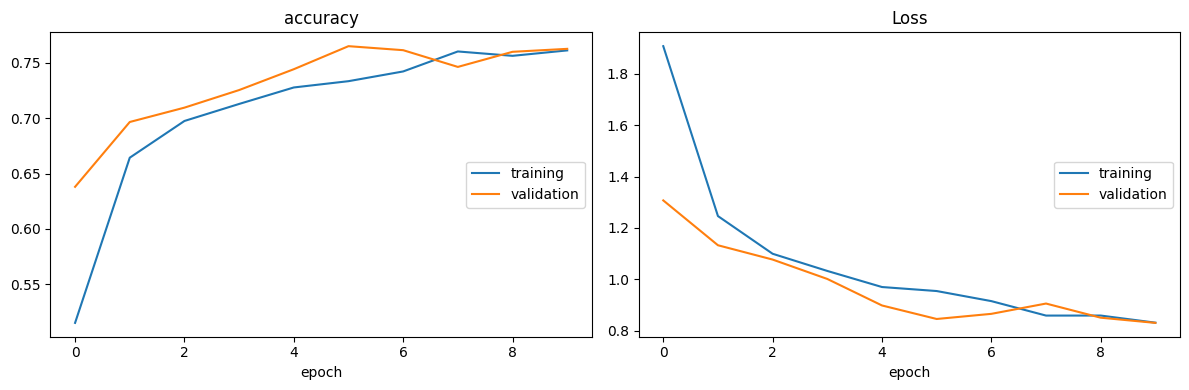

In [22]:
for epoch in range(10):
    log = {}
    train_loss = train(model, dl_train, optimizer, loss_fn, log)
    val_loss = val(model, dl_val, loss_fn, log)

    liveloss.update(log)
    liveloss.send()